# Setup

In [1]:
import sys
sys.path.insert(
    0, '/home/student.unimelb.edu.au/shorte1/Documents/TINT')

In [2]:
import sys
sys.path.insert(0, '/home/563/esh563/TINT')

In [3]:
# Core
import datetime
import os
import glob
import tempfile
import pickle
import copy

# Analysis
import numpy as np
import pandas as pd
import xarray as xr

# Plotting
import matplotlib.pyplot as plt
import matplotlib as mpl

# Debugging
import pdb, traceback
# %load_ext line_profiler

# Radar Tools
import pyart
import tint
# import tint.animate
# from tint.visualisation import animate

import CPOL_func as cf
import caine_func as caf
import analysis

# Convenience functions
%load_ext autoreload
%autoreload 1
%aimport CPOL_func
%aimport caine_func
%aimport tint.visualisation.figures
%aimport tint.visualisation.animate
%aimport tint.visualisation.horizontal_helpers
%aimport tint.visualisation.vertical_helpers
%aimport tint.tracks
%aimport tint.objects
%aimport tint.grid_utils
%aimport tint.steiner
%aimport tint.matching
%aimport tint.rain
%aimport tint.cells
%aimport tint.tracks_helpers
%aimport tint.process_ERA5
%aimport tint.process_WRF

%pdb


## You are using the Python ARM Radar Toolkit (Py-ART), an open source
## library for working with weather radar data. Py-ART is partly
## supported by the U.S. Department of Energy as part of the Atmospheric
## Radiation Measurement (ARM) Climate Research Facility, an Office of
## Science user facility.
##
## If you use this software to prepare a publication, please cite:
##
##     JJ Helmus and SM Collis, JORS 2016, doi: 10.5334/jors.119



/home/student.unimelb.edu.au/shorte1/anaconda3/envs/CPOL_analysis/lib/python3.8/site-packages/networkx/readwrite/graphml.py:346: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  (np.int, "int"), (np.int8, "int"),
/home/student.unimelb.edu.au/shorte1/anaconda3/envs/CPOL_analysis/lib/python3.8/site-packages/networkx/readwrite/gexf.py:220: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to us

Automatic pdb calling has been turned ON


In [4]:
base_dir = '/media/shorte1/Ewan\'s Hard Drive/phd/data/CPOL/'
save_dir = '/home/student.unimelb.edu.au/shorte1/Documents/TINT_tracks/'
fig_dir = '/home/student.unimelb.edu.au/shorte1/Documents/TINT_figures/'
ERA5_dir = '/media/shorte1/Ewan\'s Hard Drive/phd/data/era5/'
ERA5_dir += 'pressure-levels/reanalysis/'
WRF_dir = '/media/shorte1/Ewan\'s Hard Drive/phd/data/caine_WRF_data/'

In [8]:
base_dir = '/g/data/hj10/cpol/cpol_level_1b/v2020/gridded/grid_150km_2500m/'
save_dir = '/home/563/esh563/TINT_tracks/'
fig_dir = '/home/563/esh563/TINT_figures/'
ERA5_dir = '/g/data/rt52/era5/pressure-levels/reanalysis/'

# Create Tracks

In [5]:
b_path = '/home/student.unimelb.edu.au/shorte1/Documents/'
b_path += 'CPOL_analysis/circ_b_ind_set.pkl'
with open(b_path, 'rb') as f:
    b_ind_set = pickle.load(f)

In [19]:
start = np.datetime64('2022-03-01T00:00:00')
end = np.datetime64('2022-03-10T00:00:00')
datetimes = np.arange(start, end, np.timedelta64(10,'m'))

micro_physics = 'ACCESS'

tracks_obj  = tint.Tracks(params={
    'AMBIENT': 'ACCESS', 'AMBIENT_BASE_DIR': None,
    'GS_ALT': 0,
    'LEVELS': np.array(
        [[0, 0.5], [1, 1.5]]),
    'WIND_LEVELS': np.array(
        [[500, 3500], [500, 20000]]),
    'FIELD_THRESH': ['convective', 15],
    'MIN_SIZE': [80, 800],
    'ISO_THRESH': [10, 10],
    'INPUT_TYPE': 'ACCESS_DATETIMES'})

grids = (
    date for date in datetimes)

tracks_obj.get_tracks(grids, b_path=b_path)

Creating a reference grid.


/home/student.unimelb.edu.au/shorte1/anaconda3/envs/CPOL_analysis/lib/python3.8/site-packages/pyart/map/gates_to_grid.py:166: DeprecationWarning: Barnes weighting function is deprecated. Please use Barnes 2 to be consistent with Pauley and Wu 1990. Default will be switched to Barnes2 on June 1st.
  warnings.warn("Barnes weighting function is deprecated."


Updating ACCESS-C pseudo pyart reflectivity grid.
Getting ACCESS-G ambient winds.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 0.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 1.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 2.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 3.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 4.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 5.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 6.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 7.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 8.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 9.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 10.
Updating ACCESS-C pseudo pyart reflectivity grid.
No object

No objects found in scan 116.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 117.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 118.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 119.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 120.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 121.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 122.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 123.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 124.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 125.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 126.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 127.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 128.
Updating A

No objects found in scan 228.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 229.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 230.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 231.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 232.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 233.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 234.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 235.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 236.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 237.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 238.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 239.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 240.
Updating A

Writing tracks for scan 329.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 330.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 331.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 332.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 333.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 334.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 335.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 336.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 337.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 338.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 339.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 340.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 341.
Updating ACCESS-C 

Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 474.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 475.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 476.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 477.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 478.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 479.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 480.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 481.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 482.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 483.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 484.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 485.
Updating ACCESS-C pseudo pyart reflectiv

Getting ACCESS-G ambient winds.
Writing tracks for scan 600.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 601.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 602.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 603.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 604.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 605.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 606.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 607.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 608.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 609.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 610.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 611.
Updating ACCESS-C pseudo pyart reflectivity grid.
Updating ACCESS-

Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 704.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 705.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 706.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 707.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 708.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 709.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 710.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 711.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 712.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 713.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 714.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 715.
Updating ACCESS-C pseudo pyart reflectiv

Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 816.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 817.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 818.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 819.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 820.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 821.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 822.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 823.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 824.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 825.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 826.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 827.
Updating ACCESS-C pseudo pyart reflectiv

Writing tracks for scan 919.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 920.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 921.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 922.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 923.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 924.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 925.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 926.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 927.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 928.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 929.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 930.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 931.
Updating ACCESS-C pseud

No objects found in scan 1047.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 1048.
Updating ACCESS-C pseudo pyart reflectivity grid.
Updating ACCESS-G ambient winds.
Getting ACCESS-G ambient winds.
Writing tracks for scan 1049.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 1050.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 1051.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 1052.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 1053.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 1054.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 1055.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 1056.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 1057.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 1058.
Updating ACCESS-C pseud

Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 1151.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 1152.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 1153.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 1154.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 1155.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 1156.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 1157.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 1158.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 1159.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 1160.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 1161.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 1162.
Updating ACCESS-C pseudo pya

Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 1273.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 1274.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 1275.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 1276.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 1277.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 1278.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 1279.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 1280.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 1281.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 1282.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 1283.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 1284.
Updating ACCESS-C pseudo pya

In [13]:
current_time = str(datetime.datetime.now())[0:-7]
current_time = current_time.replace(" ", "_").replace(":", "_")
current_time = current_time.replace("-", "")
out_file_name = save_dir + 'ACCESS_test.pkl'.format(
    micro_physics, current_time)
with open(out_file_name, 'wb') as f:
    pickle.dump(tracks_obj, f)

In [20]:
tracks_obj = tint.objects.classify_tracks(tracks_obj)
tracks_obj = tint.objects.get_exclusion_categories(tracks_obj)

In [21]:
exclusions = [
    'small_area', 'large_area', 'intersect_border', 
    'intersect_border_convective', 'duration_cond', 
    'small_velocity', 'small_offset']

excluded = tracks_obj.exclusions[exclusions]
excluded = excluded.xs(0, level='level')
excluded = np.any(excluded, 1)
# excluded = excluded.where(excluded==False).dropna()
# len(excluded)/3

included = np.logical_not(excluded)
included = included.where(included==True).dropna()

In [23]:
tracks_obj.exclusions[exclusions].loc[757]

small_area  large_area  intersect_border  \
time                uid level                                             
2022-03-06 06:10:00 15  0           False       False              True   
                        1           False       False              True   
                    16  0           False       False             False   
                        1           False       False             False   

                               intersect_border_convective  duration_cond  \
time                uid level                                               
2022-03-06 06:10:00 15  0                             True           True   
                        1                             True           True   
                    16  0                            False          False   
                        1                            False          False   

                               small_velocity  small_offset  
time                uid level                                
2022-03-06 06:10:00 15  0               False         False  
                        1               False         False  
                    16  0               False         False  
                        1               False         False

In [22]:
included

scan  time                 uid
757   2022-03-06 06:10:00  16     True
758   2022-03-06 06:20:00  16     True
759   2022-03-06 06:30:00  16     True
760   2022-03-06 06:40:00  16     True
761   2022-03-06 06:50:00  16     True
762   2022-03-06 07:00:00  16     True
764   2022-03-06 07:20:00  16     True
768   2022-03-06 08:00:00  21     True
769   2022-03-06 08:10:00  21     True
770   2022-03-06 08:20:00  21     True
771   2022-03-06 08:30:00  21     True
776   2022-03-06 09:20:00  20     True
777   2022-03-06 09:30:00  20     True
778   2022-03-06 09:40:00  20     True
779   2022-03-06 09:50:00  20     True
780   2022-03-06 10:00:00  20     True
781   2022-03-06 10:10:00  20     True
782   2022-03-06 10:20:00  20     True
919   2022-03-07 09:10:00  26     True
920   2022-03-07 09:20:00  26     True
921   2022-03-07 09:30:00  26     True
922   2022-03-07 09:40:00  26     True
1049  2022-03-08 06:50:00  30     True
1051  2022-03-08 07:10:00  30     True
1052  2022-03-08 07:20:00  30    

In [33]:
with open(save_dir + 'ACCESS_test.pkl', 'rb') as f:
    tracks_obj = pickle.load(f)

In [63]:
plot_datetime = np.datetime64('2022-03-06T06:40:00')
ACCESS_refl, grid = tint.process_ACCESS.init_ACCESS_C(plot_datetime, tracks_obj.reference_grid, gadi=False)

Missing times from ACCESS-C reflectivity.


Generating figure for 2022-03-06T06:40.


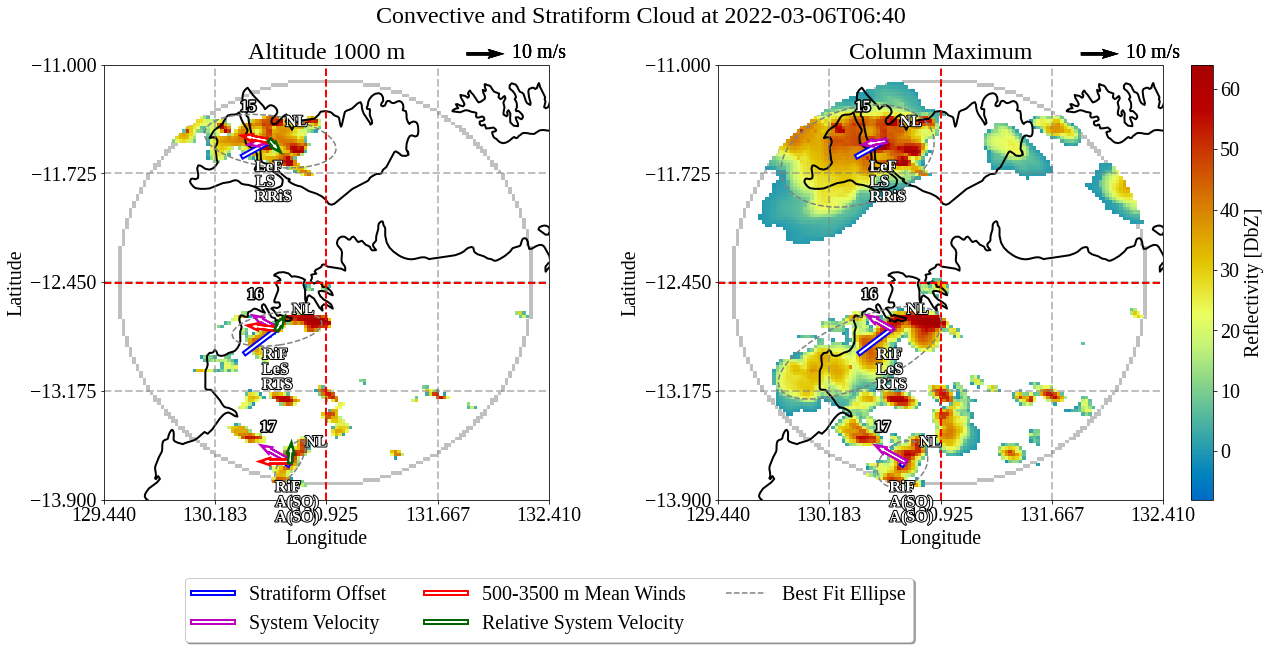

In [65]:
# filename = filenames[95]
# grid = pyart.io.read_grid(filename, include_fields=['reflectivity'])

# ACCESS_refl = tint.process_ACCESS.

current_time = str(datetime.datetime.now())[0:-7]
current_time = current_time.replace(" ", "_").replace(":", "_")
current_time = current_time.replace("-", "")

params = {
    'uid_ind': None, 'line_coords': False, 'center_cell': False,
    'cell_ind': 10, 'winds': False,
    'crosshair': True, 'fontsize': 20, 'colorbar_flag': True,
    'leg_loc': 2, 'label_type': 'velocities',
    'system_winds': ['shift', 'ambient_mean', 'relative'],
    'boundary': True, 'exclude': False}

tint.visualisation.figures.two_level(
    tracks_obj, grid, params=params, alt1=0, alt2=1)
plt.savefig(
    fig_dir + '/test_{}.png'.format(current_time), 
    dpi=200, facecolor='w', edgecolor='white', bbox_inches='tight')